# 05 — Most do środowisk ciągłych: aproksymacja + dlaczego policy-based

Do tej pory mieliśmy **tablice**:
- $V(s)$ jako wektor długości `nS`,
- $Q(s,a)$ jako macierz `nS×nA`.

W środowiskach ciągłych (np. MuJoCo):
- stan $s$ jest wektorem rzeczywistym (np. 17 wymiarów),
- często akcje też są ciągłe (np. momenty w stawach),
- tablica przestaje mieć sens.

**Most (klucz dla bloku 2):**
1) Zastępujemy tablicę funkcją $\hat V(s; w)$ (parametry `w`),  
2) TD nadal działa — ale aktualizujemy parametry:  
$
w \leftarrow w + \alpha\, \delta\, \nabla_w \hat V(s; w)
$
3) Dla akcji ciągłych argmax w Q-learning jest trudny → naturalne staje się uczenie **polityki** bezpośrednio (policy gradient).


In [6]:
import os, sys
# dodaj katalog główny repo do ścieżki importów
REPO_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if REPO_ROOT not in sys.path:
    sys.path.insert(0, REPO_ROOT)

import numpy as np
import matplotlib.pyplot as plt

In [7]:
try:
    import gymnasium as gym
except Exception:
    import gym  # type: ignore

## 1) Przykład: CartPole (ciągłe obserwacje, dyskretne akcje)

CartPole ma:
- obserwację `s` jako wektor float (ciągły),
- akcję 0/1 (dyskretna).

To jest idealny „półmost”: tablica dla stanów odpada, ale argmax po akcjach jeszcze jest prosty.
My zrobimy tylko **prediction**: nauczymy \(\hat V(s)\) dla ustalonej polityki (np. losowej).


In [8]:
env = gym.make("CartPole-v1")
obs, _ = env.reset(seed=0)
obs

array([ 0.01369617, -0.02302133, -0.04590265, -0.04834723], dtype=float32)

## 2) Liniowa aproksymacja wartości: $\hat V(s;w)=w^T \phi(s)$

Najprościej:
- $\phi(s)=[1, s_1, s_2, s_3, s_4]$ (bias + surowe cechy)

To nie jest „super model”, ale świetnie pokazuje mechanikę aktualizacji TD z parametrami.


In [9]:
# Liniowa funkcja cech φ(s)
def phi(s: np.ndarray) -> np.ndarray:
    """
    TODO (student): zdefiniuj wektor cech φ(s).
    Najprościej: [1, s1, s2, s3, s4] (bias + surowe cechy).
    """
    s = np.asarray(s, dtype=np.float64)
    # rozwiązanie:
    return np.concatenate([[1.0], s])  # (5,)

def v_hat(s: np.ndarray, w: np.ndarray) -> float:
    """Aproksymacja wartości: \hat V(s; w) = w^T φ(s)."""
    # TODO (student): policz iloczyn skalarny w · φ(s)
    return float(np.dot(w, phi(s)))  # rozwiązanie

## 3) Semi-gradient TD(0) dla $\hat V$

Uwaga: z aproksymacją i off-policy bywają problemy stabilności.  
Tu robimy **najprostszy, bezpieczny** wariant: prediction + on-policy.


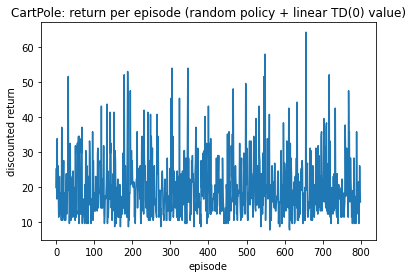

In [10]:
rng = np.random.default_rng(0)

def random_policy_cartpole(obs):
    # TODO: losowa polityka π(a|s) dla CartPole (akcje 0/1).
    return int(rng.integers(0, 2))  # rozwiązanie

def td0_linear_value(env, episodes=500, gamma=0.99, alpha=0.05, max_steps=500):
    """
    Semi-gradient TD(0) dla aproksymacji liniowej V-hat.

    Update (klucz!):
      w <- w + α * δ * ∇_w V_hat(s; w)
    gdzie:
      δ = r + γ V_hat(s') - V_hat(s)

    Dla liniowego modelu V_hat(s)=w^T φ(s) mamy:
      ∇_w V_hat(s) = φ(s)
    """
    w = np.zeros(5, dtype=np.float64)
    ep_returns = []

    for ep in range(episodes):
        s, _ = env.reset()
        G = 0.0

        for t in range(max_steps):
            a = random_policy_cartpole(s)
            sp, r, terminated, truncated, _ = env.step(a)
            G += (gamma ** t) * float(r)

            # TD target
            # TODO (student): policz target = r + γ V_hat(s') (albo r jeśli terminated albo truncated)
            

            # TD error
            # TODO (student): delta = target - V_hat(s,w)
            

            # Semi-gradient update parametrów
            # TODO (student): w += α * δ * φ(s)
            

            s = sp
            if terminated or truncated:
                break

        ep_returns.append(G)

    return w, ep_returns

w, returns = td0_linear_value(env, episodes=800, alpha=0.05)
plt.figure()
plt.plot(returns)
plt.title("CartPole: return per episode (random policy + linear TD(0) value)")
plt.xlabel("episode")
plt.ylabel("discounted return")
plt.show()

## 4) Co trzeba zrozumieć przed policy gradient?

1) **Forma update’u TD się nie zmienia**, tylko tablice → parametry.  
2) W MuJoCo akcje są ciągłe, więc:
   - „max po akcjach” w Q-learning nie jest trywialny,
   - zaczynamy uczyć **polityki** $\pi(a|s;\theta)$ bezpośrednio.
3) Actor-Critic to dokładnie to, co już znasz:
   - **critic**: TD (tyle że z aproksymacją),
   - **actor**: policy gradient.

W następnym bloku dołożymy:
- REINFORCE (policy gradient) + baseline,
- Actor-Critic,
- PPO jako „praktyczny standard”.


## Mini-ćwiczenia

1. Zmień `alpha` i zobacz, kiedy uczenie się robi niestabilne.  
2. Znormalizuj cechy `s` (np. podziel przez stałe) i porównaj stabilność.  
3. (Dyskusja) Co by było, gdyby akcje też były ciągłe?
